
# FY2021 Asset Report — Exploratory Data Analysis (EDA)

This notebook for now explores **`floor_asset_details.csv`**.  
Goals:
- Inspect schema, data quality, and missingness
- Parse dates and cast numeric fields
- Understand distributions (Age, Year) and categorical splits (Region, SVC, Place)
- Spot duplicates/outliers and high-level trends
- Build a few useful summaries and plots


In [4]:

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Display settings
pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 120)


In [19]:

# Path to CSV (adjust if needed)
CSV_PATH = r"C:\Users\dawid\Desktop\MUCKROCK\database\csv_extracted\floor_asset_details.csv"

assert os.path.exists(CSV_PATH), f"CSV not found at {CSV_PATH}"
df_raw = pd.read_csv(CSV_PATH)
print("Rows, Cols:", df_raw.shape)
df_raw.head()


Rows, Cols: (22940, 20)


,Loc,Place,Region,SVC,Asset,SerialNum,Type,Desc,Acquire,Effective,Disposed,Class,MFG,LNAME,FONUM,FOSHORT,Cat,Year,Age,Month
0,194,Floor,Europe,Army,336343,336343-657832,3084,NOV DOM PREMIUM ED 3,4/10/2015,8/24/2018,9/9/9999,60,NOV,IRISH PUB,2,KAISERSLAUTERN,SLOT,2015,5,October 2020
1,194,Floor,Europe,Army,335979,335979-647800,3083,NOV DOMINATOR IMPERA HD5/$4.00,10/30/2014,11/15/2014,9/9/9999,60,NOV,IRISH PUB,2,KAISERSLAUTERN,SLOT,2014,6,October 2020
2,194,Floor,Europe,Army,337877,337877-735489,3092,NOV CONCURVE ED 4,10/13/2017,2/23/2018,9/9/9999,60,NOV,IRISH PUB,2,KAISERSLAUTERN,SLOT,2017,3,October 2020
3,194,Floor,Europe,Army,337201,337201-XAR671631,1377,AIN/A560 MULTI WIN13 (SAP-MJP),11/30/2016,1/27/2017,9/9/9999,60,AIN,IRISH PUB,2,KAISERSLAUTERN,SLOT,2016,3,October 2020
4,194,Floor,Europe,Army,337200,337200-XAR671630,1375,AIN/A560 MULTI WIN5 (SAP-MJP),11/30/2016,1/27/2017,9/9/9999,60,AIN,IRISH PUB,2,KAISERSLAUTERN,SLOT,2016,3,October 2020


In [6]:

print("=== Columns ===")
print(list(df_raw.columns))

print("\n=== Dtypes ===")
print(df_raw.dtypes)

print("\n=== % Missing by Column ===")
missing = df_raw.isna().mean().sort_values(ascending=False).to_frame("%_missing")
missing


=== Columns ===
['Loc', 'Place', 'Region', 'SVC', 'Asset', 'SerialNum', 'Type', 'Desc', 'Acquire', 'Effective', 'Disposed', 'Class', 'MFG', 'LNAME', 'FONUM', 'FOSHORT', 'Cat', 'Year', 'Age', 'Month']

=== Dtypes ===
Loc           int64
Place        object
Region       object
SVC          object
Asset        object
SerialNum    object
Type         object
Desc         object
Acquire      object
Effective    object
Disposed     object
Class        object
MFG          object
LNAME        object
FONUM         int64
FOSHORT      object
Cat          object
Year         object
Age          object
Month        object
dtype: object

=== % Missing by Column ===


,%_missing
Desc,0.004228
LNAME,0.001351
Loc,0.000000
Place,0.000000
SVC,0.000000
Region,0.000000
SerialNum,0.000000
Asset,0.000000
Acquire,0.000000
Effective,0.000000


In [7]:

# Clean/standardize column names to snake_case
def to_snake(s):
    return (s.strip()
              .replace("#","num")
              .replace("/","_")
              .replace(" ","_")
              .replace("-","_")
              .replace("__","_")
              .lower())

df = df_raw.copy()
df.columns = [to_snake(c) for c in df.columns]
df.head(3)


,loc,place,region,svc,asset,serialnum,type,desc,acquire,effective,disposed,class,mfg,lname,fonum,foshort,cat,year,age,month
0,194,Floor,Europe,Army,336343,336343-657832,3084,NOV DOM PREMIUM ED 3,4/10/2015,8/24/2018,9/9/9999,60,NOV,IRISH PUB,2,KAISERSLAUTERN,SLOT,2015,5,October 2020
1,194,Floor,Europe,Army,335979,335979-647800,3083,NOV DOMINATOR IMPERA HD5/$4.00,10/30/2014,11/15/2014,9/9/9999,60,NOV,IRISH PUB,2,KAISERSLAUTERN,SLOT,2014,6,October 2020
2,194,Floor,Europe,Army,337877,337877-735489,3092,NOV CONCURVE ED 4,10/13/2017,2/23/2018,9/9/9999,60,NOV,IRISH PUB,2,KAISERSLAUTERN,SLOT,2017,3,October 2020


In [8]:

date_cols = [c for c in df.columns if c in {"acquire","effective","disposed"} or "date" in c]
for c in date_cols:
    df[c] = pd.to_datetime(df[c], errors="coerce")

# heuristic numeric columns
num_like = {"age","year"}
num_like |= {c for c in df.columns if c.endswith("_num") or c in {"fonum","asset"}}
for c in num_like:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

print("Parsed date columns:", date_cols)
print("Casted numeric-ish columns:", sorted(set(num_like) & set(df.columns)))
df[sorted([c for c in df.columns if c in (set(date_cols) | set(num_like))])].head(3)


Parsed date columns: ['acquire', 'effective', 'disposed']
Casted numeric-ish columns: ['age', 'asset', 'fonum', 'year']


C:\Users\dawid\AppData\Local\Temp\ipykernel_4912\1686696532.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[c] = pd.to_datetime(df[c], errors="coerce")


,acquire,age,asset,disposed,effective,fonum,year
0,2015-04-10,5.0,336343.0,NaT,2018-08-24,2,2015.0
1,2014-10-30,6.0,335979.0,NaT,2014-11-15,2,2014.0
2,2017-10-13,3.0,337877.0,NaT,2018-02-23,2,2017.0


In [9]:

print("=== Basic sanity checks ===")
print("Unique regions:", df["region"].nunique() if "region" in df.columns else "N/A")
print("Unique services:", df["svc"].nunique() if "svc" in df.columns else "N/A")
print("Unique places:", df["place"].nunique() if "place" in df.columns else "N/A")

dupe_cols = [c for c in ["loc","place","region","svc","asset","serialnum","desc","lname","fonum","foshort"] if c in df.columns]
dupes = df.duplicated(subset=dupe_cols, keep=False) if dupe_cols else pd.Series([False]*len(df))
print("Duplicate rows (by key subset):", dupes.sum(), "of", len(df))

df.describe(include="all").transpose().head(20)


=== Basic sanity checks ===
Unique regions: 12
Unique services: 11
Unique places: 11
Duplicate rows (by key subset): 22839 of 22940


,count,unique,top,freq,mean,min,25%,50%,75%,max,std
loc,22940.0,NaN,NaN,NaN,1790.906408,194.0,839.0,1669.0,3072.0,3170.0,1096.789366
place,22940,11,Floor,22842,NaN,NaN,NaN,NaN,NaN,NaN,NaN
region,22940,12,Europe,9074,NaN,NaN,NaN,NaN,NaN,NaN,NaN
svc,22940,11,Army,12720,NaN,NaN,NaN,NaN,NaN,NaN,NaN
asset,18543.0,NaN,NaN,NaN,329090.113304,116226.0,335783.0,336877.0,337603.0,339250.0,38928.075377
serialnum,22940,2355,Floor,75,NaN,NaN,NaN,NaN,NaN,NaN,NaN
type,22940,667,1018,1152,NaN,NaN,NaN,NaN,NaN,NaN,NaN
desc,22843,369,ITC Smart Card Dispenser,1152,NaN,NaN,NaN,NaN,NaN,NaN,NaN
acquire,22864,NaN,NaN,NaN,2014-09-26 18:35:50.174947584,1999-01-01 00:00:00,2014-03-08 00:00:00,2016-09-16 00:00:00,2017-11-15 00:00:00,2021-04-08 00:00:00,NaN
effective,22842,NaN,NaN,NaN,2017-01-31 06:14:39.432624128,2001-08-01 00:00:00,2015-10-25 00:00:00,2018-01-27 00:00:00,2019-05-29 00:00:00,2021-08-03 00:00:00,NaN


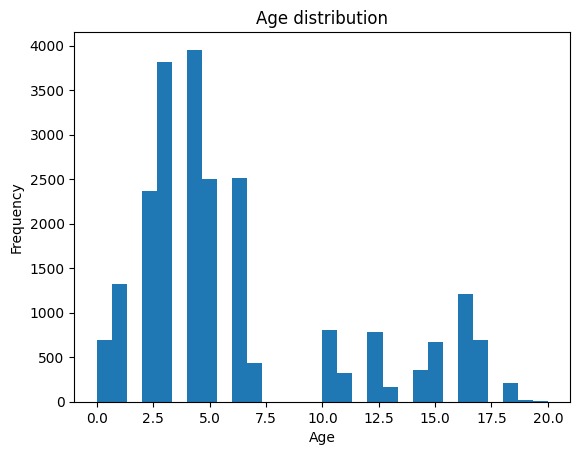

In [10]:

if "age" in df.columns:
    plt.figure()
    df["age"].dropna().astype(float).plot(kind="hist", bins=30, title="Age distribution")
    plt.xlabel("Age")
    plt.show()


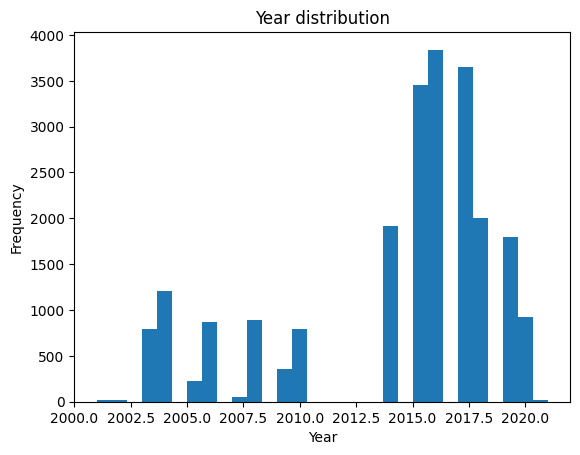

In [11]:

if "year" in df.columns:
    plt.figure()
    df["year"].dropna().astype(float).plot(kind="hist", bins=30, title="Year distribution")
    plt.xlabel("Year")
    plt.show()


In [12]:

def top_counts(col, n=10):
    if col in df.columns:
        vc = df[col].astype("string").value_counts(dropna=False).head(n)
        display(vc.to_frame("count"))

for c in ["region","svc","place","lname","mfg","class","type"]:
    top_counts(c)


,count
region,
Europe,9074
Japan,8545
Korea,5223
"CTR,",22
CITY,11
"CLUB,",11
VAULT,11
LODGE,11
ZAMA,11


,count
svc,
Army,12720
Navy,5823
Marine,4299
CP,33
BOWL,11
CLUB,11
&,11
GOLF,11
TOWN,11


,count
place,
Floor,22842
BOWL,11
WINDY,11
EDELWEISS,11
COMM,11
BOWLING,11
THE,11
CAMP,11
CAPO,11


,count
lname,
DRAGON HILL LODGE,983
OCEAN BREEZE,837
MORNING CALM,726
TAIYO GOLF COURSE,582
PALMS,520
CAVE,462
IRISH PUB,460
IWAKUNI CLUB,458
THE ARENA B/C,432


,count
mfg,
NOV,7327
BAL,4462
IGT,3063
AIN,2244
ITC,1388
WMS,1188
DIE,1162
KON,1065
IBM,797


,count
class,
60,19385
70,2579
740,797
66,81
Army,28
Camp,18
13,11
19,11
Daegu,6


,count
type,
1018,1152
9001,955
3084,748
2038,667
3216,655
4018,652
4011,611
3126,598
3234,501


In [13]:

group_cols = [c for c in ["region","svc"] if c in df.columns]
if "age" in df.columns and group_cols:
    g = (df.groupby(group_cols)["age"]
           .agg(["count","mean","median","min","max"])
           .sort_values("count", ascending=False))
    display(g.head(20))


count       mean  median  min   max
region  svc                                        
Europe  Army     7040   6.054261     4.0  0.0  18.0
Korea   Army     4889   5.217427     4.0  0.0  18.0
Japan   Marine   4299   6.400791     4.0  0.0  20.0
        Navy     3455   5.469175     5.0  0.0  18.0
Europe  Navy     2034   7.053589     5.0  0.0  18.0
Japan   Army      791   6.131479     5.0  0.0  18.0
Korea   Navy      334  10.817365    12.0  3.0  17.0
CANTINA EL          0        NaN     NaN  NaN   NaN
CTR,    CP          0        NaN     NaN  NaN   NaN
CITY    BOWL        0        NaN     NaN  NaN   NaN
CLUB    Floor       0        NaN     NaN  NaN   NaN
CLUB,   CP          0        NaN     NaN  NaN   NaN
LODGE   &           0        NaN     NaN  NaN   NaN
OLDE    TOWN        0        NaN     NaN  NaN   NaN
VAULT   CLUB        0        NaN     NaN  NaN   NaN
ZAMA    GOLF        0        NaN     NaN  NaN   NaN

In [14]:

key = [c for c in ["region","svc","lname","place"] if c in df.columns]
if key:
    top_sites = (df.groupby(key)
                   .size()
                   .reset_index(name="asset_count")
                   .sort_values("asset_count", ascending=False)
                   .head(25))
    display(top_sites)


,region,svc,lname,place,asset_count
87,Korea,Army,DRAGON HILL LODGE,Floor,983
61,Japan,Marine,OCEAN BREEZE,Floor,837
94,Korea,Army,MORNING CALM,Floor,726
65,Japan,Marine,TAIYO GOLF COURSE,Floor,582
62,Japan,Marine,PALMS,Floor,520
85,Korea,Army,CAVE,Floor,462
20,Europe,Army,IRISH PUB,Floor,460
60,Japan,Marine,IWAKUNI CLUB,Floor,458
34,Europe,Army,THE ARENA B/C,Floor,432
17,Europe,Army,ENTERTAINMENT CENTER GRAF,Floor,416


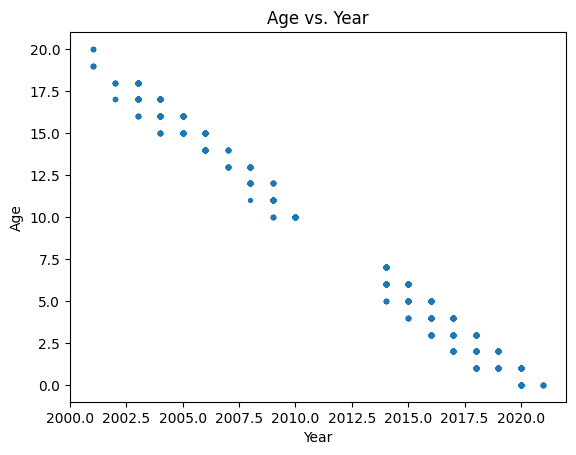

In [15]:

if set(["age","year"]).issubset(df.columns):
    plt.figure()
    df_subset = df[["age","year"]].dropna().astype(float)
    plt.scatter(df_subset["year"], df_subset["age"], s=8)
    plt.xlabel("Year")
    plt.ylabel("Age")
    plt.title("Age vs. Year")
    plt.show()


In [16]:

if "age" in df.columns:
    q1, q3 = df["age"].quantile([0.25, 0.75])
    iqr = q3 - q1
    upper = q3 + 1.5*iqr
    lower = q1 - 1.5*iqr
    print("Age IQR bounds:", lower, upper)
    outliers = df[(df["age"] < lower) | (df["age"] > upper)]
    print("Num age outliers:", len(outliers))
    display(outliers.head(10))


Age IQR bounds: -1.5 10.5
Num age outliers: 4423


,loc,place,region,svc,asset,serialnum,type,desc,acquire,effective,disposed,class,mfg,lname,fonum,foshort,cat,year,age,month
33,194,Floor,Europe,Army,333083.0,333083-26963,1018,ITC Smart Card Dispenser,2004-08-21,2005-04-12,NaT,70,ITC,IRISH PUB,2,KAISERSLAUTERN,ACM/ITC,2004.0,16.0,October 2020
36,194,Floor,Europe,Army,333066.0,333066-R10620538926,9001,DIEBOLD ACM,2003-08-21,2005-12-10,NaT,70,DIE,IRISH PUB,2,KAISERSLAUTERN,ACM/ITC,2003.0,17.0,October 2020
37,194,Floor,Europe,Army,333092.0,333092-1406879,1283,IGT FENG SHUI 10C 25L .01,2004-12-02,2005-01-29,NaT,60,IGT,IRISH PUB,2,KAISERSLAUTERN,SLOT,2004.0,15.0,October 2020
38,194,Floor,Europe,Army,333425.0,333425-23708,1018,ITC Smart Card Dispenser,2003-12-05,2004-02-19,NaT,70,ITC,IRISH PUB,2,KAISERSLAUTERN,ACM/ITC,2003.0,16.0,October 2020
39,194,Floor,Europe,Army,333889.0,333889-1406874,579,IGT iGAME AZTEC TEMPLE 243 01,2004-11-09,2019-07-12,NaT,60,IGT,IRISH PUB,2,KAISERSLAUTERN,SLOT,2004.0,15.0,October 2020
40,194,Floor,Europe,Army,333896.0,333896-1406883,228,IGT GAME KING CL IFACE 210,2004-11-09,2012-10-19,NaT,60,IGT,IRISH PUB,2,KAISERSLAUTERN,SLOT,2004.0,15.0,October 2020
41,194,Floor,Europe,Army,335465.0,335465-R10620538851,9001,DIEBOLD ACM,2006-07-07,2011-02-25,NaT,70,DIE,IRISH PUB,2,KAISERSLAUTERN,ACM/ITC,2006.0,14.0,October 2020
45,194,Floor,Europe,Army,334919.0,334919-33644,1018,ITC Smart Card Dispenser,2006-02-17,2006-09-28,NaT,70,ITC,IRISH PUB,2,KAISERSLAUTERN,ACM/ITC,2006.0,14.0,October 2020
76,195,Floor,Europe,Army,334920.0,334920-33645,1018,ITC Smart Card Dispenser,2006-02-17,2006-12-05,NaT,70,ITC,LCCC,2,KAISERSLAUTERN,ACM/ITC,2006.0,14.0,October 2020
77,195,Floor,Europe,Army,334150.0,334150-R10620538839,9001,DIEBOLD ACM,2006-02-22,2007-11-07,NaT,70,DIE,LCCC,2,KAISERSLAUTERN,ACM/ITC,2006.0,14.0,October 2020


In [17]:

OUT_CSV = r"C:\Users\dawid\Desktop\MUCKROCK\database\csv_output\floor_asset_details_clean.csv"
os.makedirs(os.path.dirname(OUT_CSV), exist_ok=True)
df.to_csv(OUT_CSV, index=False)
OUT_CSV


'C:\\Users\\dawid\\Desktop\\MUCKROCK\\database\\csv_output\\floor_asset_details_clean.csv'